<h1 style="color:rgb(0,120,170)">Machine Learning: Unsupervised Techniques</h1>
<h1 style="color:rgb(0,120,170)">Assignment 1: Estimation Theory, Fisher Information, CRLB</h1>

Let us start with some preliminary facts and intuition on why it is often a good idea to use the logarithm in optimization tasks, like parameter estimation:

* log is strictly monotonically increasing, so log likelihood is a strictly monotonically increasing transformation of likelihood and maxima occur at same parameter values
    * $p(x;\theta_1) > p(x;\theta_2) \Leftrightarrow \ln p(x;\theta_1) > \ln p(x;\theta_2)$
    * $\textrm{argmax}_\theta\ p(x;\theta) = \textrm{argmax}_\theta \ln p(x;\theta)$    
* products become sums
    * $L = p_1 p_2 p_3$
    * $\ln(L) = \ln(p_1) + \ln(p_2) + \ln(p_3)$
* derivatives are easier
    * $\frac{\partial L}{\partial \theta} = 
    \frac{\partial p_1}{\partial \theta} p_2 p_3 +
    p_1 \frac{\partial p_2}{\partial \theta} p_3 +
    p_1 p_2 \frac{\partial p_3}{\partial \theta}
    $
    * $\frac{\partial \ln(L)}{\partial \theta} = 
    \frac{\partial \ln(p_1)}{\partial \theta} +
    \frac{\partial \ln(p_2)}{\partial \theta} + 
    \frac{\partial \ln(p_3)}{\partial \theta}$
* likelihoods become very small and consequently they run out of floating point precision very quickly
    * log likelihoods are numerically more stable
* for some distributions the log space avoids expansive computation
    * exp in gaussian pdf:
        * $p(x; \theta) = \frac{1}{(\sqrt{2\pi})^{d}\sqrt{det \Sigma}}\,\exp^{-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)}$
    * no exp in log space:
        * $\ln p(x; \theta) = -\frac{d}{2}\ln(2\pi) -\frac{1}{2}\ln(\textrm{det} \Sigma) - \frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)$

Let us also briefly visualize the situation with a plot of the log-likelihood vs. the actual likelihood. You should see that the logarithm is just a monotonic function, so it doesn't change the actual optimization problem at hand.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

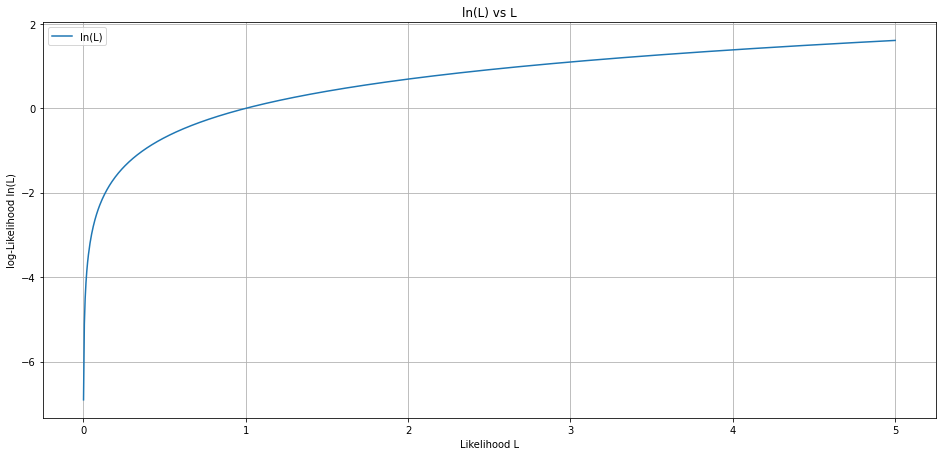

In [24]:
# plot of likelihood vs. log-likelihood

L = np.linspace(0.001,5,1000)
L_ln = np.log(L)

fig = plt.figure(figsize=(16,16))
plt.subplot(2,1,1)
plt.plot(L, L_ln, label='ln(L)')
plt.xlabel('Likelihood L')
plt.ylabel('log-Likelihood ln(L)')
plt.grid()
plt.legend()
plt.title("ln(L) vs L");

<h2 style="color:rgb(0,120,170)">Task 1: On the Fisher Information of Gaussians</h2>

Consider a sequence of independent and identically distributed (i.i.d.) random variables $x_{1}, x_{2},...,x_{n}$ that are sampled from a normal distribution with an unknown expectation parameter $\mu$ and a known standard deviation parameter $\sigma$, i.e.
$x_{i}$ are distributed according to the density function

$$
p(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\, \text{exp}^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}
$$

Let us start this task by creating 3 normally distributed datasets with same $\mu = 5$ but different $\sigma = 1,3,10$.
We also want to visualize their histograms and compare with the actual densities. The procedure should be clearly visible from the code below.

In [25]:
def gauss_function(x, mu, sigma):
    """ This is the 1D gaussian probability density function with mean mu and standard deviation sigma """
    
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

In [26]:
def generate_data(mu, sigma, samples):
    """ This funtion generates the data """
    
    x = np.linspace(-15,25,samples)
    
    # get density over x
    density = gauss_function(x, mu, sigma)
    
    # sample for the gaussian distribution
    X_samples = sigma*np.random.randn(n) + mu # np.random.randn(n: gives us the number of numbers which
    # shall be generated randomly (each))
    
    return x, density, X_samples

In [27]:
# here we generate 3 datasets with 500 samples each with same mu = 5 but different sigmas = 1,3,10

n = 500
mu = 5.0
sigma_1 = 1.0
sigma_2 = 3.0
sigma_3 = 10.0

x, p1, X1 = generate_data(mu, sigma_1, samples=n)
_, p2, X2 = generate_data(mu, sigma_2, samples=n)
_, p3, X3 = generate_data(mu, sigma_3, samples=n)


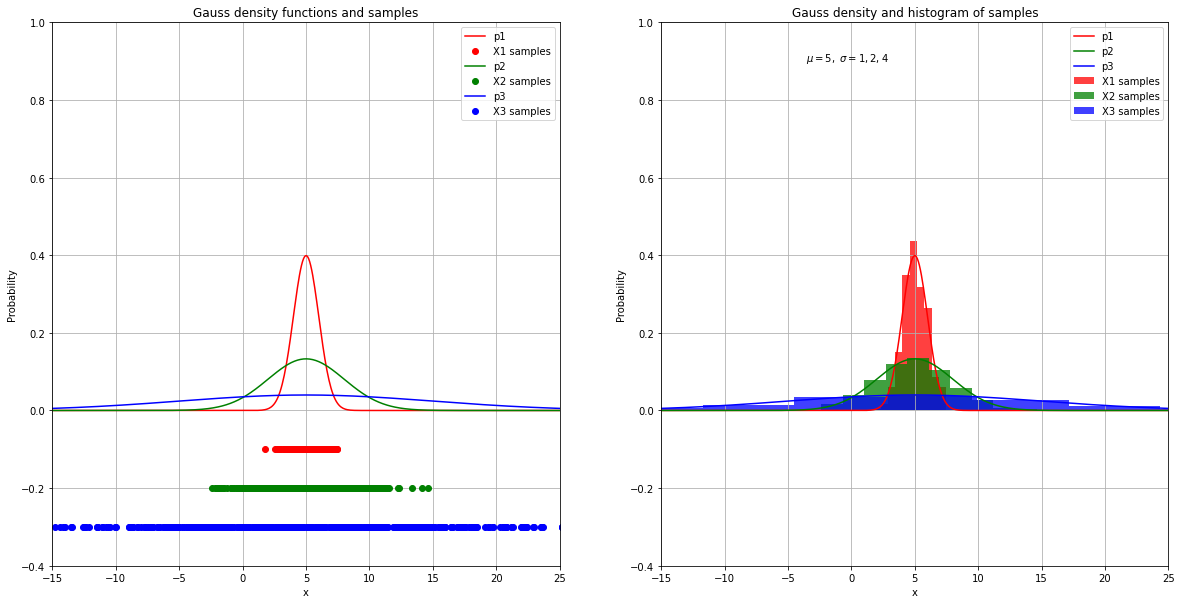

In [28]:
# this code is only for plotting

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(x, p1, label='p1', color='r')
plt.plot(X1, np.repeat(-0.1, len(x)), 'ro', label='X1 samples')
plt.plot(x, p2, label='p2', color='g')
plt.plot(X2, np.repeat(-0.2, len(x)), 'go', label='X2 samples')
plt.plot(x, p3, label='p3', color='b')
plt.plot(X3, np.repeat(-0.3, len(x)), 'bo', label='X3 samples')
plt.axis([-15, 25, -0.4, 1.0])
plt.grid()
plt.title('Gauss density functions and samples')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()

# the histogram of the data

plt.subplot(1,2,2)
n, bins, patches = plt.hist(X1, density=True, facecolor='r', alpha=0.75, label='X1 samples')
plt.plot(x, p1, label='p1', color='r')
n, bins, patches = plt.hist(X2, density=True, facecolor='g', alpha=0.75, label='X2 samples')
plt.plot(x, p2, label='p2', color='g')
n, bins, patches = plt.hist(X3, density=True, facecolor='b', alpha=0.75, label='X3 samples')
plt.plot(x, p3, label='p3', color='b')
plt.legend()

plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Gauss density and histogram of samples')
plt.text(-3.6, 0.9, r'$\mu=5,\ \sigma=1,2,4$')
plt.axis([-15, 25, -0.4, 1.0])
plt.grid(True)
plt.show()

Next we want to work with the likelihood and log-likelihood of the previously created data. To this end, recall the following definitions:

**Likelihood:**
$$\mathcal{L}(w) = \prod_{i=1}^n p(x_i ; w)$$

**Log-Likelihood:**
$$\ln\mathcal{L}(w) = \sum_{i=1}^n \ln p(x_i ; w)$$

<h3 style="color:rgb(0,120,170)">Task 1.1:</h3>

* As a first task, implement the log-likelihood function for a given dataset, a given $\mu$ and a given $\sigma$, using the previously implemented functions. Test your function by executing the print commands below.

<h3 style="color:rgb(208,90,80)">Code (10 points)</h3>

In [29]:
# Calculate the log-likehood function; it should return a scalar value
import math
from numpy import log 
from scipy.stats import multivariate_normal
def log_likelihood(data, mu, sigma):
    """ Calculates the log likelihood"""
    
    ######################################################################
    # Begin To Do: Implement the log_likelihood
    lnL = 0
    for xi in data:
        pi = -0.5*np.log(2*math.pi*sigma**2) - (xi-mu)**2/2*sigma**2
        lnL += pi
        #  Or:
        # lnL = lnL + np.log(gauss_function(i,mu,sigma))

        
    # End To Do
    ######################################################################
        
    return lnL

In [30]:
print("ln(L)(X1,mu=5,sigma1) = %8.1f" % log_likelihood(X1, mu=5, sigma=sigma_1))
print("ln(L)(X1,mu=5,sigma2) = %8.1f" % log_likelihood(X1, mu=5, sigma=sigma_2))
print("ln(L)(X1,mu=5,sigma3) = %8.1f" % log_likelihood(X1, mu=5, sigma=sigma_3))
print("\n")
print("ln(L)(X2,mu=5,sigma1) = %8.1f" % log_likelihood(X2, mu=5, sigma=sigma_1))
print("ln(L)(X2,mu=5,sigma2) = %8.1f" % log_likelihood(X2, mu=5, sigma=sigma_2))
print("ln(L)(X2,mu=5,sigma3) = %8.1f" % log_likelihood(X2, mu=5, sigma=sigma_3))
print("\n")
print("ln(L)(X3,mu=5,sigma1) = %8.1f" % log_likelihood(X3, mu=5, sigma=sigma_1))
print("ln(L)(X3,mu=5,sigma2) = %8.1f" % log_likelihood(X3, mu=5, sigma=sigma_2))
print("ln(L)(X3,mu=5,sigma3) = %8.1f" % log_likelihood(X3, mu=5, sigma=sigma_3))

ln(L)(X1,mu=5,sigma1) =   -680.1
ln(L)(X1,mu=5,sigma2) =  -2994.3
ln(L)(X1,mu=5,sigma3) = -23672.1


ln(L)(X2,mu=5,sigma1) =  -2725.1
ln(L)(X2,mu=5,sigma2) = -21399.6
ln(L)(X2,mu=5,sigma3) = -228175.5


ln(L)(X3,mu=5,sigma1) = -26313.9
ln(L)(X3,mu=5,sigma2) = -233698.4
ln(L)(X3,mu=5,sigma3) = -2587050.5


You should be able to see that the log-likelihood for data set $X_i$ is largest for $\sigma_i$.

Now let us gain some intuition on how the log-likelihood function behaves, if data and $\sigma$ are given, but $\mu$ varies in the set $[-5,15]$. 

<h3 style="color:rgb(0,120,170)">Task 1.2:</h3>

* Your task is to complete the implementation of the function calculate_log_likelihood_over_mu so that it outputs the list mu_set (which has already been created) and an array lnL_array. This array should contain the log-likelihoods calculated from data set $X$, $\sigma$ and $\mu_i$. Afterwards, compute the estimators $\hat{\mu}$ (argmax) and execute the plotting routine for the different values of $\sigma$.

<h3 style="color:rgb(208,90,80)">Code (20 points)</h3>

In [31]:
def calculate_log_likelihood_over_mu(data, sigma):
    
    mu_set = np.linspace(-5,15,501) # start with -5 go to 15 in 501 steps
    lnL_list = [] # each entry is log likelihood of on mu in mu_set

    ######################################################################
    # Begin To Do
    for mu in mu_set:
        lnL = 0
        for xi in data:
            pi = -0.5*np.log(2*math.pi*sigma**2) - (xi-mu)**2/2*sigma**2
            lnL += pi
            # Or:
            # lnL = log_likelihood(data, mu=mu_i, sigma=sigma)
            #lnL_list.append(lnL)
        lnL_list.append(lnL)
        
    
    
    # End To Do
    ######################################################################
    
    lnL_array = np.array(lnL_list)
    return mu_set, lnL_array

In [32]:
mu_set, lnL_array1 = calculate_log_likelihood_over_mu(X1, sigma_1)
_, lnL_array2 = calculate_log_likelihood_over_mu(X2, sigma_2)
_, lnL_array3 = calculate_log_likelihood_over_mu(X3, sigma_3)

In [33]:
print("mu-hat = argmax_mu(lnL(X1,mu,sigma1)): %4.2f" % mu_set[np.argmax(lnL_array1)])
print("mu-hat = argmax_mu(lnL(X2,mu,sigma2)): %4.2f" % mu_set[np.argmax(lnL_array2)])
print("mu-hat = argmax_mu(lnL(X3,mu,sigma3)): %4.2f" % mu_set[np.argmax(lnL_array3)])

mu-hat = argmax_mu(lnL(X1,mu,sigma1)): 5.04
mu-hat = argmax_mu(lnL(X2,mu,sigma2)): 4.92
mu-hat = argmax_mu(lnL(X3,mu,sigma3)): 5.12


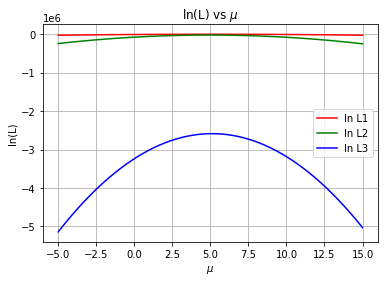

In [34]:
plt.plot(mu_set, lnL_array1, label='ln L1', color='r')
plt.plot(mu_set, lnL_array2, label='ln L2', color='g')
plt.plot(mu_set, lnL_array3, label='ln L3', color='b')
plt.grid()
plt.legend()
plt.title("ln(L) vs $\mu$")
plt.ylabel("ln(L)");
plt.xlabel('$\mu$');

It is likely that the estimator $\hat{\mu}$ is closest to the true value $\mu = 5$ for $\sigma_1$ and deviates most for $\sigma_3$.

Run all cells again several times (including new random data from the fixed probability distribution) to get a feeling for the statistics.

<h3 style="color:rgb(0,120,170)">Task 1.3:</h3>

In the previous tasks you should have gained some intuition on how the variance of an unbiased estimator for $\mu$ behaves in certain situations (i.e. for different $\sigma$. Now we want to confirm these observations with a rigorous calculation on the lower bound of this variance:

* Determine/Calculate the Cramer-Rao lower bound for the variance of an unbiased estimator for the parameter $\mu$ for the situation described at the beginning of task 1.

To do this, work through the following steps:

1. Using (25), calculate the Log-Likelihood with the probability density function $p(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\, \text{exp}^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$ for $n$ data samples.
2. Verify formula (27) on slide 17 for this situation to simplify the calculation of $\mathbf{I}_{F}(\mu)$.
3. Use the simplified (curvature) formula (31) to calculate $\mathbf{I}_{F}(\mu)$. In our case, it will be a scalar $I_F$ as the parameter is also a scalar.
4. Calculate $\text{CRLB}$ from the result of step 3

If you did everything right, you should end up with $\text{CRLB} = \frac{\sigma^2}{n}$

<h3 style="color:rgb(210,90,80)">Calculation (30 points):</h3>

Your calculation here.

1. Using (25), calculate the Log-Likelihood with the probability density function $p(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\, \text{exp}^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$ for $n$ data samples.
\begin{align*}
ln(L)&=\sum_{i=1}^{n} ln(p(x_i;\mu)) \\
&=\sum_{i=1}^{n} ln(\frac{1}{\sqrt{2\pi\sigma^2}} e^{\frac{-(x_i-\mu)^2}{2\sigma^2}}) \\
&=\sum_{i=1}^{n} ln(\frac{1}{\sqrt{2\pi\sigma^2}}) + ln(e^{\frac{-(x_i-\mu)^2}{2\sigma^2}}) \\
&=\sum_{i=1}^{n} \frac{1}{2} ln(\frac{1}{2\pi\sigma^2}) - \frac{(x_i-\mu)^2}{2\sigma^2} \\
&=\sum_{i=1}^{n} \frac{1}{2} (ln(1) - ln(2\pi\sigma^2)) - \frac{(x_i-\mu)^2}{2\sigma^2} \\
&=\sum_{i=1}^{n} \frac{-1}{2}ln(2\pi\sigma^2) - \frac{(x_i-\mu)^2}{2\sigma^2} \\
&= \frac{-n}{2}ln(2\pi\sigma^2) - \sum_{i=1}^{n} \frac{(x_i-\mu)^2}{2\sigma^2} \\
\end{align*}

2. Verify formula (27) on slide 17 for this situation to simplify the calculation of $\mathbf{I}_{F}(\mu)$.

\begin{align*}
\text{To show: }
E_{p(x;\mu)}(\frac{\partial ln(L(\mu))}{\partial \mu}) &= 0 \\
E_{p(x;\mu)}(\frac{1}{L}\frac{\partial L(\mu)}{\partial \mu}) &= \\
&=\int_{-inf}^{inf}...\int_{-inf}^{inf}\frac{\prod_{i=1}^n p_i}{\prod_{i=1}^n p_i}\frac{\partial \prod_{i=1}^n p_i} {\partial \mu}dx_1 ... dx_n\\
&=\int_{-inf}^{inf}...\int_{-inf}^{inf}\frac{\partial \prod_{i=1}^n p_i} {\partial \mu}dx_1 ... dx_n\\
\\
&=\int_{-inf}^{inf}...\int_{-inf}^{inf}\frac{\partial \frac{1}{(\sqrt(2 \pi \sigma^2)^n} e^{\frac{\sum_{i=1}^n (x_i-\mu)^2}{-2\sigma^2}}} {\partial \mu}dx_1 ... dx_n\\
\\
&=\frac{1}{(\sqrt{2 \pi \sigma^2})^n} \int_{-inf}^{inf}...\int_{-inf}^{inf} \frac{-2\sum_{i=1}^n (x_i-\mu)}{-2\sigma^2e^{\frac{\sum_{i=1}^n (x_i-\mu)^2}{2\sigma^2}}} dx_1 ... dx_n\\
\\
\\
&=\frac{1}{\sigma^2(\sqrt{2 \pi \sigma^2})^n} \int_{-inf}^{inf}...\int_{-inf}^{inf} \frac{\sum_{i=1}^n (x_i-\mu)}{e^{\frac{\sum_{i=1}^n (x_i-\mu)^2}{2\sigma^2}}} dx_1 ... dx_n\\
\\
\\
&=\frac{1}{\sigma^2(\sqrt{2 \pi \sigma^2})^n} \int_{-inf}^{inf}...\int_{-inf}^{inf} (\frac{-1}{2e^{\frac{(x_1\sum_{i=2}^n (x_i-\mu))+\frac{(x_1-\mu)^2}{2}}{2\sigma^2}}})_{-inf}^{inf} dx_2 ... dx_n\\
\\
&=\frac{1}{\sigma^2(\sqrt{2 \pi \sigma^2})^n} \int_{-inf}^{inf}...\int_{-inf}^{inf} (0 - 0) dx_2 ... dx_n\\
\\
&=0
\\
\\
\\
\\
\\
\end{align*}

3. Use the simplified (curvature) formula (31) to calculate $\mathbf{I}_{F}(\mu)$. In our case, it will be a scalar $I_F$ as the parameter is also a scalar.

\begin{align*}
I_F(\mu) &= - E_{p(x;\mu)}(\frac{\partial^2 ln(L(\mu))}{\partial \mu \partial \mu}) \\
&= - E_{p(x;\mu)}(\frac{\frac{-n}{2}ln(2\pi \sigma^2) - \sum_{i=1}^n \frac{(x- \mu)^2}{2 \sigma^2}}
{\partial \mu \partial \mu}) \\
&= - E_{p(x;\mu)}(\frac{0 - \sum_{i=1}^n (-2)\frac{(x- \mu)}{2 \sigma^2}}
{\partial \mu }) \\
&= - E_{p(x;\mu)}(\frac{\sum_{i=1}^n \frac{(x- \mu)}{ \sigma^2}}
{\partial \mu }) \\
&= - E_{p(x;\mu)}(\sum_{i=1}^n \frac{(-1)}{ \sigma^2}
) \\
&=  E_{p(x;\mu)}(\sum_{i=1}^n \frac{1}{ \sigma^2}
) \\
&=  E_{p(x;\mu)}(\frac{n}{ \sigma^2}
) \\
&=  \frac{n}{ \sigma^2}\\
\end{align*}

4. Calculate $\text{CRLB}$ from the result of step 3

\begin{align*}
Var(\hat\mu) >= \frac{1}{I_F(\mu)} = \frac{1}{\frac{n}{\sigma^2}} = \frac{\sigma^2}{n} = CRLB
\end{align*}

Solution of lecture: 

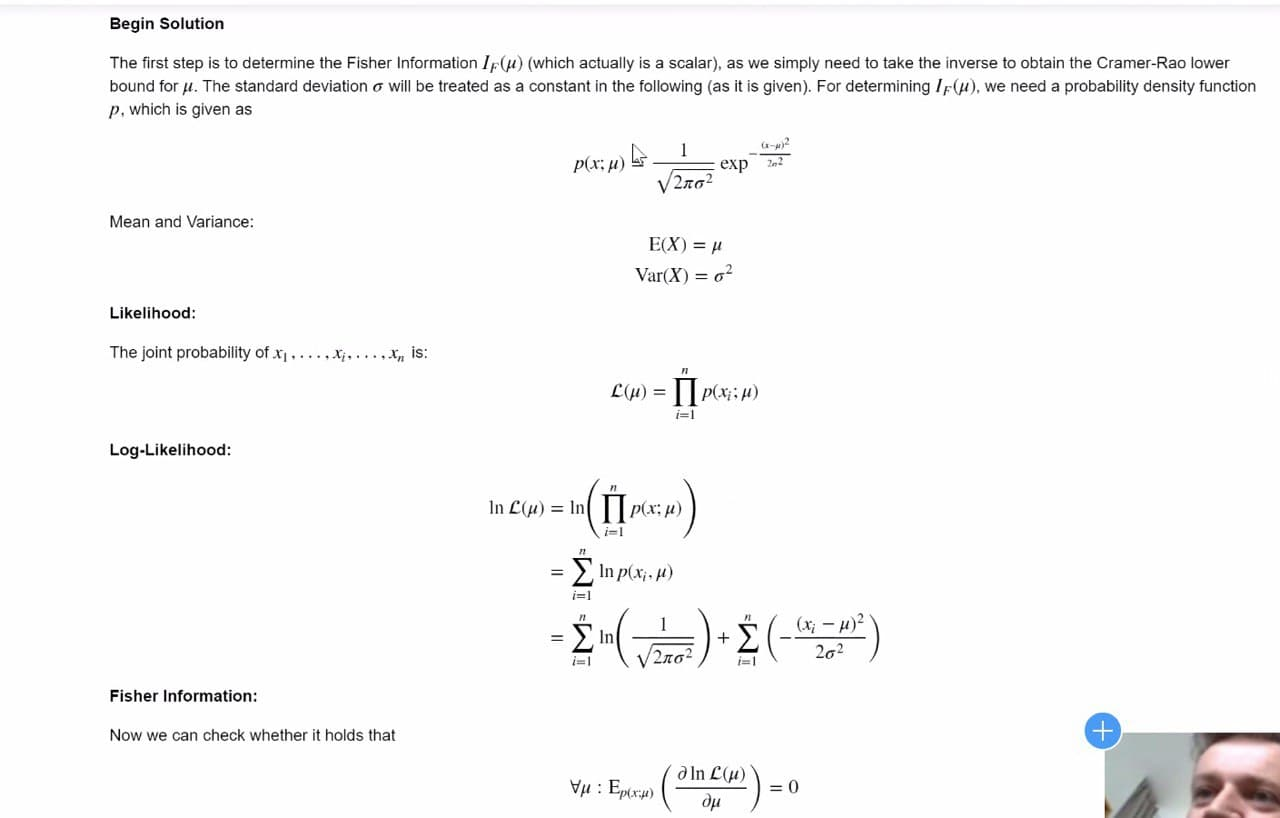

In [7]:
from IPython.display import Image
Image("pic1_as1.jpg")


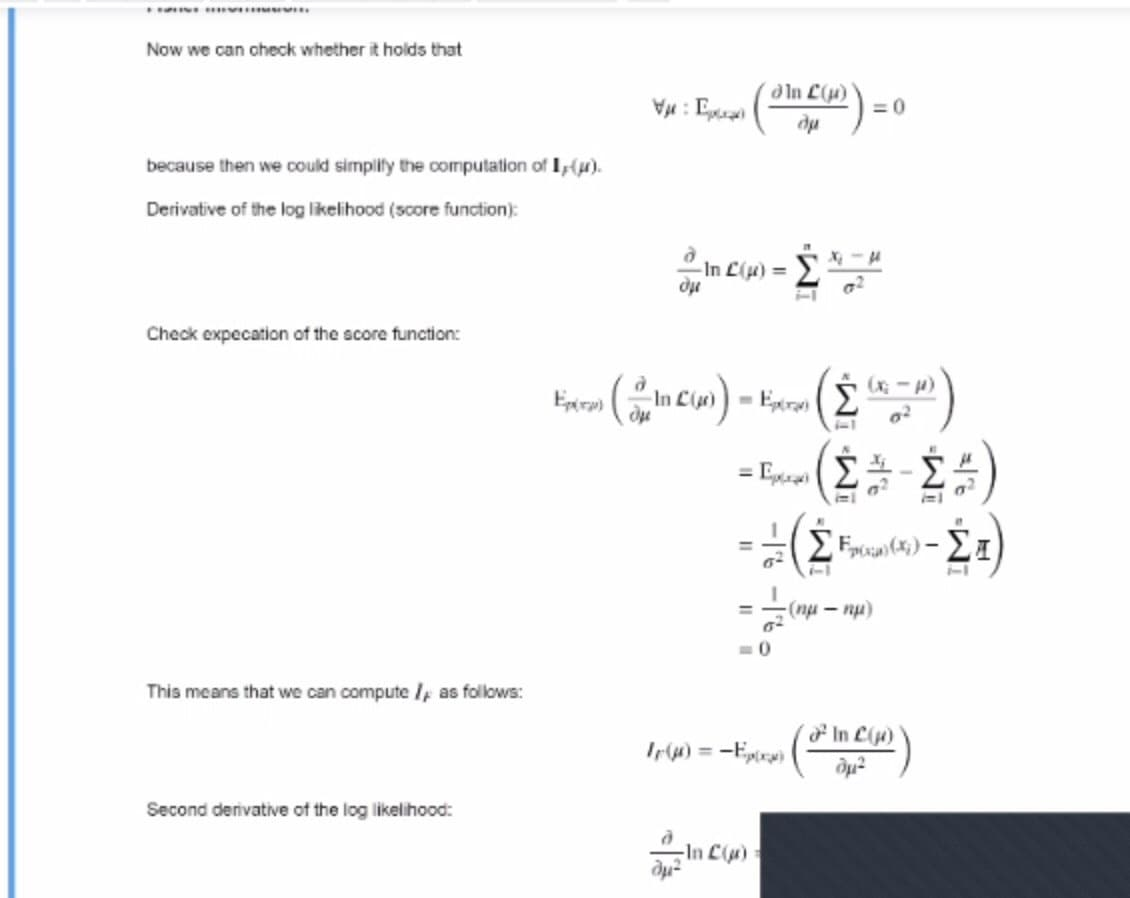

In [11]:
Image("pic2_as1.jpg")


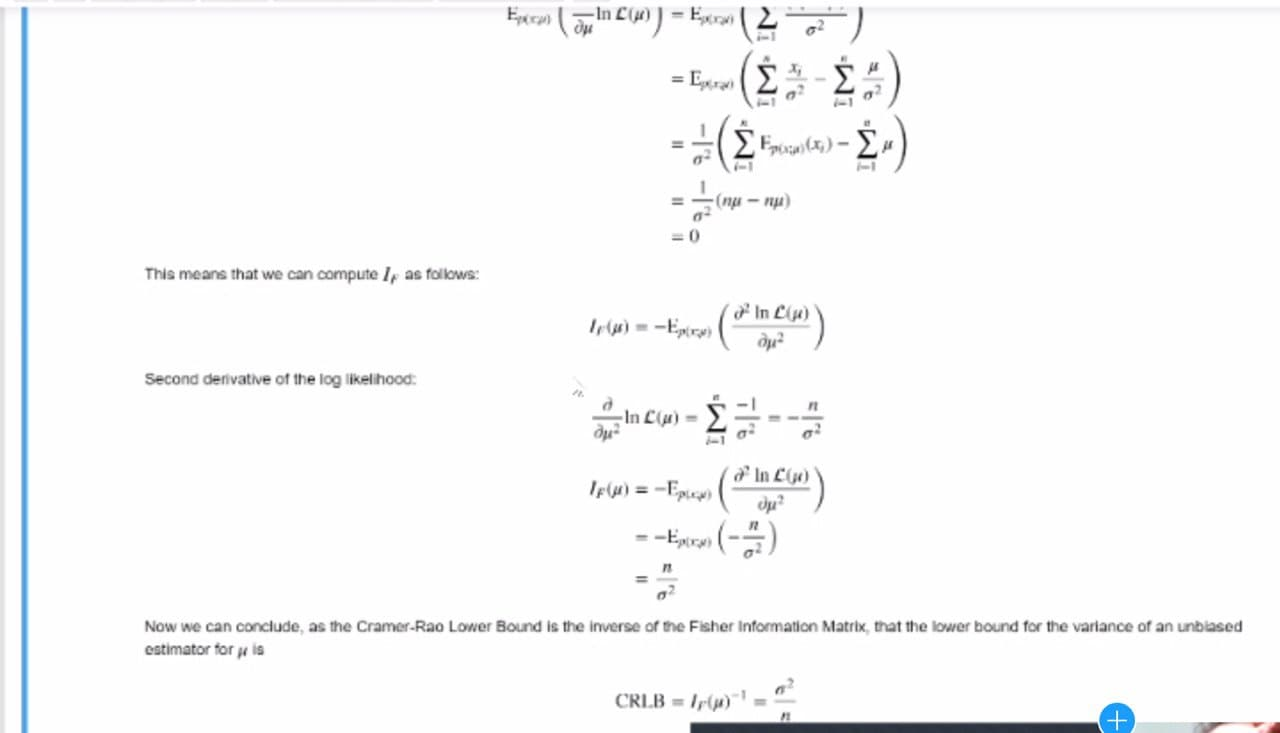

In [12]:
Image("pic3_as1.jpg")


<h3 style="color:rgb(0,120,170)">Task 1.4:</h3>

* Now you are asked to implement the result of the previous task, i.e. provide a function that outputs the Fisher information for a given number $n$ of data samples and $\sigma$.

<h3 style="color:rgb(208,90,80)">Code (5 points)</h3>

In [35]:
def fisher_information_mu(n, sigma):
    """ Calculate the fisher information  """
    
    ######################################################################
    # Begin To Do: Implement the result from above
    return n/sigma**2
    

    # End To Do
    ######################################################################

In [36]:
print("IF(mu) with sigma1: IF = %6.2f" %fisher_information_mu(n=500,sigma=sigma_1))
print("IF(mu) with sigma2: IF = %6.2f" %fisher_information_mu(n=500,sigma=sigma_2))
print("IF(mu) with sigma3: IF = %6.2f" %fisher_information_mu(n=500,sigma=sigma_3))

IF(mu) with sigma1: IF = 500.00
IF(mu) with sigma2: IF =  55.56
IF(mu) with sigma3: IF =   5.00


<h3 style="color:rgb(0,120,170)">Task 1.5:</h3>

<h3 style="color:rgb(208,90,80)">Question (5 points)</h3>

Finally answer some questions on your observations (2 sentences in total are enough):
* How does the variance of the estimator of the mean $\mu$ depend on standard deviation $\sigma$ and sample number $n$?
* Which values of $\sigma$ are better for estimating $\mu$?

* How does the variance of the estimator of the mean $\mu$ depend on standard deviation $\sigma$ and sample number $n$? <br>
We have a high variance when the stadard deviation is small. With a increasing standard deviation value the variance of the estimator of the mean shrinks. <br>
The bigger the sample number the larger the variance of the estimator of the mean.<br><br>

* Which values of $\sigma$ are better for estimating $\mu$?<br>
High values of $\sigma$ are better for estimating because then we have a small variance of estimator of the mean which means that there are only few $\mu$ which could be correct. So, we are more probable to choose the right $\hat\mu$.

<h2 style="color:rgb(0,120,170)">Task 2: Estimation properties of arithmetic mean</h2>

In this task, we want to prove some easy properties of the arithmetic mean as an estimator for the mean of the sample given in task 1.

<h3 style="color:rgb(0,120,170)">Task 2.1:</h3>

* Consider the estimator $\hat\mu = \sum_{i}^{n} \frac{1}{n} x_{i}$ i.e. the aritmetic mean of the observations. Show that this is an unbiased estimator for the parameter $\mu$.

<h3 style="color:rgb(210,90,80)">Calculation (15 points):</h3>

Your calculation here.

\begin{align*}
&E(\frac{1}{n}\sum_{i=1}^n x_i) = \frac{1}{n} E(\sum_{i=1}^n x_i) = \frac{1}{n} (E(x_1)+ E(x_2)+...+E(x_n))
=  \frac{1}{n} \sum_{i=1}^n E(x_i) = \frac{1}{n} \sum_{i=1}^n \mu = \mu \\
&Bias = E(\frac{1}{n}\sum_{i=1}^n x_i) - \mu = \mu  - \mu = 0 
\end{align*}
--> Estimator is unbiased.

Solution: E_X(mu-hat)= same = 1/n * n * mu = mu

<h3 style="color:rgb(0,120,170)">Task 2.2:</h3>

* Check if the estimator $\hat\mu = \frac{1}{n} \sum_{i}^{n} x_{i}$ is efficient.

<h3 style="color:rgb(210,90,80)">Calculation (15 points):</h3>

Your calculation here.

We already know CRLB = $\frac{\sigma^2}{n}$ for unbiased estimators. <br>
We need: Var($\hat\mu$) = CRLB<br>
\begin{align*}
Var(\hat\mu)=Var(\frac{1}{n}\sum_{i=1}^n x_i) = \frac{1}{n^2}Var(\sum_{i=1}^n x_i) = \frac{1}{n^2}\sum_{i=1}^nVar(x_i) = \frac{\sigma^2}{n}
\end{align*}
--> Condition is fulfilled. So, the estimator is efficient.